In [3]:
from google.cloud import storage
import pandas as pd 
import numpy as np

In [14]:
pip install xgboost

     |████████████████████████████████| 173.5 MB 9.4 kB/s             █████▉       | 134.7 MB 82.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
# Classification metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import cohen_kappa_score
# Ignore ConvergenceWarning messages
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

In [6]:
train = pd.read_csv('gs://credit-risk-bucket/application_train.csv', sep=",")
train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Data Cleaning
train['OCCUPATION_TYPE'].value_counts()/len(train) 
train['OCCUPATION_TYPE'].unique()
train['OCCUPATION_TYPE'].replace([ 'Cleaning staff', 'Cooking staff', 'Accountants', 'Medicine staff'
        'Private service staff', 'Security staff','Waiters/barmen staff',
        'Low-skill Laborers', 'Realty agents', 'Secretaries', 'IT staff', 'HR staff'], 'Others', inplace= True)
train['ORGANIZATION_TYPE'].value_counts()/len(train) 
train['ORGANIZATION_TYPE'].replace(['School', 'Religion',
       'Other','Electricity', 'Medicine',
       'Transport: type 2',
       'Construction', 'Housing', 'Kindergarten', 'Trade: type 7',
       'Industry: type 11', 'Military', 'Services', 'Security Ministries',
       'Transport: type 4', 'Industry: type 1', 'Emergency', 'Security',
       'Trade: type 2', 'University', 'Transport: type 3', 'Police',
       'Business Entity Type 1', 'Postal', 'Industry: type 4',
       'Agriculture', 'Restaurant', 'Culture', 'Hotel',
       'Industry: type 7', 'Trade: type 3', 'Industry: type 3', 'Bank',
       'Industry: type 9', 'Insurance', 'Trade: type 6',
       'Industry: type 2', 'Transport: type 1', 'Industry: type 12',
       'Mobile', 'Trade: type 1', 'Industry: type 5', 'Industry: type 10',
       'Legal Services', 'Advertising', 'Trade: type 5', 'Cleaning',
       'Industry: type 13', 'Trade: type 4', 'Telecom',
       'Industry: type 8', 'Realtor', 'Industry: type 6'], 'Others', inplace = True)
outlier = train[train['DAYS_EMPLOYED'] == 365243]
train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True) # replace outlier by 
train['DAYS_EMPLOYED'].fillna(np.mean(train['DAYS_EMPLOYED']), inplace= True) # fill na with by mean of the column
train['TARGET'].value_counts()/len(train) # Outlier had lower rate of default (target = 1)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

In [9]:
# Feature engineering
train['Credit_income_ratio'] = train['AMT_CREDIT']/train['AMT_INCOME_TOTAL']
train['Anuity_income_ratio'] = train['AMT_ANNUITY']/train['AMT_INCOME_TOTAL'] 
train['Credit_term'] = train['AMT_ANNUITY']/train['AMT_CREDIT'] #length of the payment in months since the annuity is the monthly amount due
train['Days_employed_age'] = train['DAYS_EMPLOYED']/train['DAYS_BIRTH']

In [11]:
corr = train.corr()['TARGET'].sort_values()
corr.head(10)

EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
Days_employed_age            -0.055310
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64

In [12]:
corr = train.corr()['TARGET'].sort_values()
corr.tail(10)

REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.070075
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [13]:
# Convert categorical feature to numberic using one-hot encoding
train = pd.get_dummies(train, drop_first= True)

In [15]:
# Training model
y = train['TARGET']
X = train.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=1234)
pipeline = make_pipeline(StandardScaler(), XGBClassifier()) # PCA(n_components = 175)
params = {
    'xgbclassifier__learning_rate': [0.05, 0.1], #[0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
    'xgbclassifier__max_depth': [3, 5], #[3, 4, 5, 6, 8, 10, 12, 15],
    'xgbclassifier__min_child_weight': [3, 7], #[1, 3, 5, 7, 9, 11] "stop trying to split once your sample size in a node goes below a given threshold".
    'xgbclassifier__gamma' : [0.2,0.3], #[0, 0.1, 0.2, 0.3], minimum loss reduction required to make a split.
    'xgbclassifier__colsample_bytree':  [0.3, 0.7], #[0.3, 0.5, 0.7, 1]           
}
model = RandomizedSearchCV(pipeline, params, n_iter=1, scoring='roc_auc', cv=5, n_jobs=-1, verbose = 3)
model.fit(X_train, y_train)
model.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:58:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7542897196010543

In [16]:
# Trained model parameters
model.best_params_

{'xgbclassifier__min_child_weight': 3,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__gamma': 0.3,
 'xgbclassifier__colsample_bytree': 0.7}

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3;, score=0.751 total time= 2.9min
[15:54:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 4/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3;, score=0.753 total time= 2.9min


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3;, score=0.753 total time= 2.9min


In [17]:
# Model performance on testset
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] 
print('XGBoost AUC', roc_auc_score(y_test, pred))
pred_class = model.predict(X_test)

XGBoost AUC 0.767454044145506


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:54:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3;, score=0.758 total time= 2.9min
[15:57:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 5/5] END xgbclassifier__colsample_bytree=0.7, xgbclassifier__gamma=0.3, xgbclassifier__learning_rate=0.1, xgbclassifier__max_depth=3, xgbclassifier__min_child_weight=3;, score=0.755 total time=  33.2s


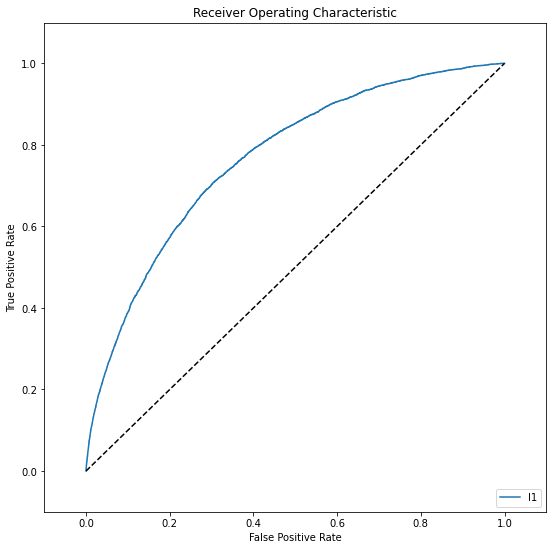

In [20]:
# Class Probabilities
pred = model.predict_proba(X_test)
pred = [p[1] for p in pred] # Positive class (1) probabilities

# Calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y_test, pred)

# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [21]:
# AUROC - Area under ROC curve
roc_auc_score(y_test, pred)

0.767454044145506